In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data_25_25/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)
N = coords.shape[0]

In [4]:
dt = 0.004
S = 501

u = lib.utils.read_data(S, N, '2d_burger_data_25_25/time_step_', 'vel_0')
u.shape

torch.Size([501, 2601])

In [5]:
u_min = torch.min(u)
u_max = torch.max(u)

u = 2*u/(u_max-u_min) - (u_max+u_min)/(u_max-u_min)

In [6]:
n = 20

In [7]:
batch_size = 10
u = u.to(device)
dataloader = DataLoader(u, batch_size=batch_size, shuffle=True)

In [8]:
ed = lib.nrbs_ade.EncoderDecoder(N=N, n=n, device=device)

In [9]:
# model_name = "models/ade.pth"
# ed.nrbs = torch.load(model_name)

In [10]:
ed.train(dataloader, effective_batch=250, epochs=10000)

100%|██████████| 51/51 [00:01<00:00, 35.00it/s]


Initial loss = 16166.382384954359


100%|██████████| 51/51 [00:01<00:00, 49.17it/s]


Itr 0, curr_loss = 19498.232063782118, best_loss = 16166.382384954359, lr = 0.0001


100%|██████████| 51/51 [00:01<00:00, 49.15it/s]


Itr 1, curr_loss = 6635.945640217657, best_loss = 6635.945640217657, lr = 0.0001


100%|██████████| 51/51 [00:01<00:00, 49.26it/s]


Itr 2, curr_loss = 1587.5968338937116, best_loss = 1587.5968338937116, lr = 0.0001


100%|██████████| 51/51 [00:01<00:00, 48.88it/s]


Itr 3, curr_loss = 3293.204129177962, best_loss = 1587.5968338937116, lr = 0.0001


  8%|▊         | 4/51 [00:00<00:03, 15.01it/s]


KeyboardInterrupt: 

In [ ]:
approximates = ed(u[500:501].to(device))
approximates.shape

torch.Size([1, 2601])

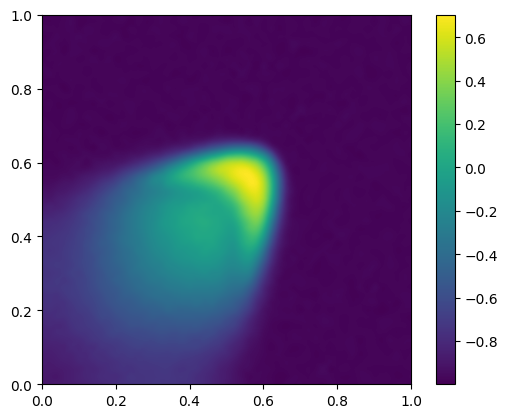

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

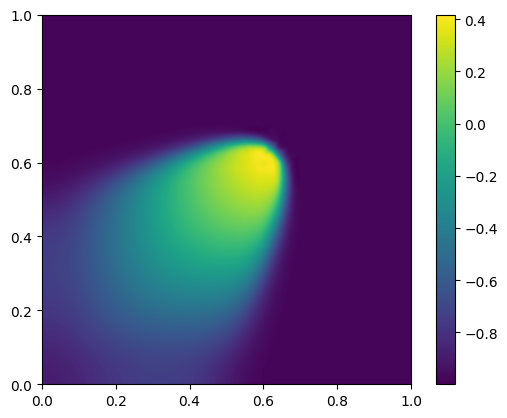

In [ ]:
z = u[500].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

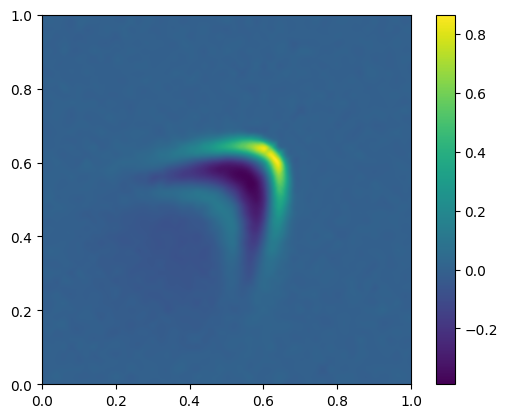

In [ ]:
z = (u[500] - approximates[0]).detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
(0.8 + (u_max + u_min) / (u_max - u_min)) * (u_max - u_min) / 2

tensor(0.2690)